In [2]:
# IMPORTS
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# **CONFIG BLOCK**

In [3]:
DATA_DIR = "/kaggle/input/lung-disease/Lung X-Ray Image/Lung X-Ray Image" 
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.0001
SPLIT_TRAIN = 0.7
SPLIT_VAL = 0.15
SPLIT_TEST = 0.15

# **DATA PREPROCESSING BLOCK**

In [4]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=SPLIT_VAL + SPLIT_TEST
)

train_gen = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# split validation/test
val_test_datagen = ImageDataGenerator(rescale=1./255, validation_split=SPLIT_TEST / (SPLIT_VAL + SPLIT_TEST))

val_gen = val_test_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

test_gen = val_test_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 2433 images belonging to 3 classes.
Found 1738 images belonging to 3 classes.
Found 1737 images belonging to 3 classes.


# **VGG16 MODEL BUILDING BLOCK**

In [5]:
# BUILD VGG16 FROM SCRATCH 
model = Sequential([
    
    Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(*IMG_SIZE, 3)),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2), strides=(2,2)),

    
    Conv2D(128, (3,3), activation='relu', padding='same'),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2), strides=(2,2)),

    
    Conv2D(256, (3,3), activation='relu', padding='same'),
    Conv2D(256, (3,3), activation='relu', padding='same'),
    Conv2D(256, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2), strides=(2,2)),

   
    Conv2D(512, (3,3), activation='relu', padding='same'),
    Conv2D(512, (3,3), activation='relu', padding='same'),
    Conv2D(512, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2), strides=(2,2)),

   
    Conv2D(512, (3,3), activation='relu', padding='same'),
    Conv2D(512, (3,3), activation='relu', padding='same'),
    Conv2D(512, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2), strides=(2,2)),

    
    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(train_gen.num_classes, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1763060610.552244      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


# **MODEL COMPILATION AND TRAINING**

In [6]:
#  COMPILE 
optimizer = Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

#  TRAIN 
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_vgg16_model.h5', monitor='val_accuracy', save_best_only=True)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[early_stop, checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1763060624.231467     126 service.cc:148] XLA service 0x7bd4d0019ad0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763060624.232265     126 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1763060624.960281     126 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1763060645.253503     126 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.3842 - loss: 1.0397

77/77 ━━━━━━━━━━━━━━━━━━━━ 68s 557ms/step - accuracy: 0.3859 - loss: 1.0378 - val_accuracy: 0.7733 - val_loss: 0.5368
Epoch 2/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.7856 - loss: 0.5283

77/77 ━━━━━━━━━━━━━━━━━━━━ 27s 354ms/step - accuracy: 0.7854 - loss: 0.5288 - val_accuracy: 0.7796 - val_loss: 0.5656
Epoch 3/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.8222 - loss: 0.4781

77/77 ━━━━━━━━━━━━━━━━━━━━ 27s 355ms/step - accuracy: 0.8220 - loss: 0.4780 - val_accuracy: 0.8516 - val_loss: 0.3794
Epoch 4/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.8557 - loss: 0.3747

77/77 ━━━━━━━━━━━━━━━━━━━━ 28s 361ms/step - accuracy: 0.8556 - loss: 0.3747 - val_accuracy: 0.8723 - val_loss: 0.3459
Epoch 5/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.8576 - loss: 0.3585

77/77 ━━━━━━━━━━━━━━━━━━━━ 27s 350ms/step - accuracy: 0.8577 - loss: 0.3582 - val_accuracy: 0.8959 - val_loss: 0.2719
Epoch 6/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 22s 285ms/step - accuracy: 0.8930 - loss: 0.2830 - val_accuracy: 0.8936 - val_loss: 0.2733
Epoch 7/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 23s 292ms/step - accuracy: 0.8920 - loss: 0.2830 - val_accuracy: 0.8947 - val_loss: 0.2631
Epoch 8/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 22s 285ms/step - accuracy: 0.9047 - loss: 0.2664 - val_accuracy: 0.8746 - val_loss: 0.2912
Epoch 9/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9072 - loss: 0.2462

77/77 ━━━━━━━━━━━━━━━━━━━━ 28s 363ms/step - accuracy: 0.9072 - loss: 0.2460 - val_accuracy: 0.9229 - val_loss: 0.1950
Epoch 10/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 22s 284ms/step - accuracy: 0.9099 - loss: 0.2302 - val_accuracy: 0.9143 - val_loss: 0.2215
Epoch 11/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9118 - loss: 0.2428

77/77 ━━━━━━━━━━━━━━━━━━━━ 28s 365ms/step - accuracy: 0.9117 - loss: 0.2429 - val_accuracy: 0.9361 - val_loss: 0.1772
Epoch 12/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 22s 283ms/step - accuracy: 0.9312 - loss: 0.1931 - val_accuracy: 0.9258 - val_loss: 0.1907
Epoch 13/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9189 - loss: 0.2024

77/77 ━━━━━━━━━━━━━━━━━━━━ 28s 362ms/step - accuracy: 0.9190 - loss: 0.2023 - val_accuracy: 0.9465 - val_loss: 0.1297
Epoch 14/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9459 - loss: 0.1414

77/77 ━━━━━━━━━━━━━━━━━━━━ 27s 350ms/step - accuracy: 0.9458 - loss: 0.1416 - val_accuracy: 0.9528 - val_loss: 0.1179
Epoch 15/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 22s 285ms/step - accuracy: 0.9296 - loss: 0.1991 - val_accuracy: 0.9264 - val_loss: 0.1858
Epoch 16/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9343 - loss: 0.1609

77/77 ━━━━━━━━━━━━━━━━━━━━ 28s 359ms/step - accuracy: 0.9343 - loss: 0.1608 - val_accuracy: 0.9603 - val_loss: 0.1010
Epoch 17/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9564 - loss: 0.1130

77/77 ━━━━━━━━━━━━━━━━━━━━ 28s 359ms/step - accuracy: 0.9565 - loss: 0.1130 - val_accuracy: 0.9718 - val_loss: 0.0815
Epoch 18/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9686 - loss: 0.0854

77/77 ━━━━━━━━━━━━━━━━━━━━ 28s 365ms/step - accuracy: 0.9685 - loss: 0.0855 - val_accuracy: 0.9735 - val_loss: 0.0669
Epoch 19/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 22s 283ms/step - accuracy: 0.9687 - loss: 0.0881 - val_accuracy: 0.9603 - val_loss: 0.0869
Epoch 20/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9637 - loss: 0.0866

77/77 ━━━━━━━━━━━━━━━━━━━━ 28s 362ms/step - accuracy: 0.9637 - loss: 0.0867 - val_accuracy: 0.9839 - val_loss: 0.0480


# **EVALUATION AND METRICS**

55/55 ━━━━━━━━━━━━━━━━━━━━ 14s 251ms/step - accuracy: 0.8896 - loss: 0.3245

 Test Accuracy: 92.80%
 Test Loss: 0.2320
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step

========== Classification Report ==========
                 precision    recall  f1-score   support

   Lung_Opacity     0.9112    0.8950    0.9031       562
         Normal     0.9157    0.9040    0.9098       625
Viral Pneumonia     0.9577    0.9891    0.9732       550

       accuracy                         0.9280      1737
      macro avg     0.9282    0.9294    0.9287      1737
   weighted avg     0.9276    0.9280    0.9277      1737



<Figure size 800x600 with 0 Axes>

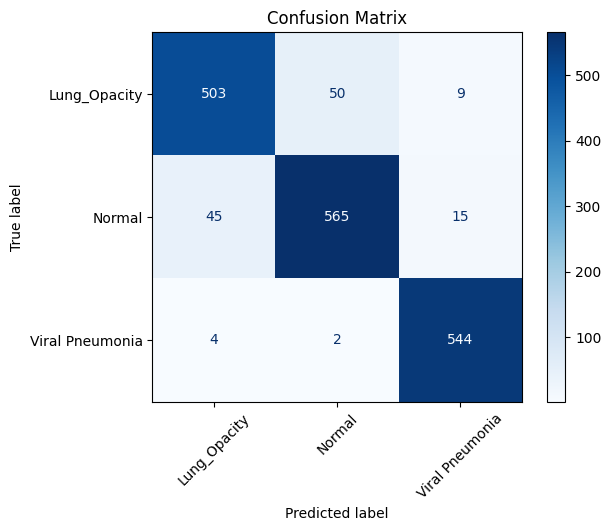

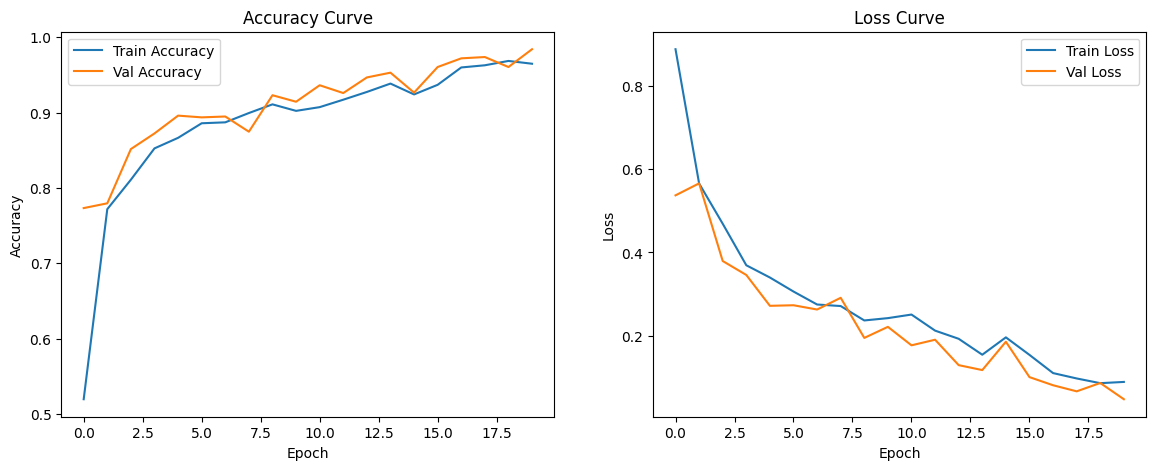

In [7]:
# EVALUATE
test_loss, test_acc = model.evaluate(test_gen)
print(f"\n Test Accuracy: {test_acc*100:.2f}%")
print(f" Test Loss: {test_loss:.4f}")

# METRICS: CONFUSION MATRIX, PRECISION, RECALL, F1 Score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Get true labels and predictions
Y_true = test_gen.classes
Y_pred_probs = model.predict(test_gen)
Y_pred = np.argmax(Y_pred_probs, axis=1)

# Labels (class names)
class_labels = list(test_gen.class_indices.keys())

# Classification report
print("\n========== Classification Report ==========")
print(classification_report(Y_true, Y_pred, target_names=class_labels, digits=4))

# Confusion matrix
cm = confusion_matrix(Y_true, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

plt.figure(figsize=(8,6))
disp.plot(cmap='Blues', xticks_rotation=45, values_format='d')
plt.title("Confusion Matrix")
plt.show()

#  PLOTS 
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()